In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

%matplotlib inline

In [5]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('u.user', sep='|', names=u_cols,
                    encoding='latin-1', parse_dates=True) 

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

movie_ratings = pd.merge(movies, ratings)
df = pd.merge(movie_ratings, users)

df.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


In [6]:
df.shape

(100000, 12)

In [7]:
df = df.drop(["video_release_date","imdb_url","unix_timestamp"], axis=1)
ratings.drop( "unix_timestamp", inplace = True, axis = 1 ) 
movies.drop(movies.columns[[3,4]], inplace = True, axis = 1 )
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
movie_id        100000 non-null int64
title           100000 non-null object
release_date    99991 non-null object
user_id         100000 non-null int64
rating          100000 non-null int64
age             100000 non-null int64
sex             100000 non-null object
occupation      100000 non-null object
zip_code        100000 non-null object
dtypes: int64(4), object(5)
memory usage: 7.6+ MB


In [8]:
np.random.seed(0) 
missing_values_count = movies.isnull().sum()
print(missing_values_count)

movie_id        0
title           0
release_date    1
dtype: int64


In [9]:
movie_status = df.groupby("title").agg({'rating': [np.size, np.mean]})
movie_status.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

In [11]:
min_50 = movie_status["rating"]["size"] >= 50
movie_status[min_50].sort_values([("rating","size")], ascending=False).head()

rating          
                            size      mean
title                                     
Star Wars (1977)             583  4.358491
Contact (1997)               509  3.803536
Fargo (1996)                 508  4.155512
Return of the Jedi (1983)    507  4.007890
Liar Liar (1997)             485  3.156701

Text(0.5, 0, 'Rating (Out of 5)')

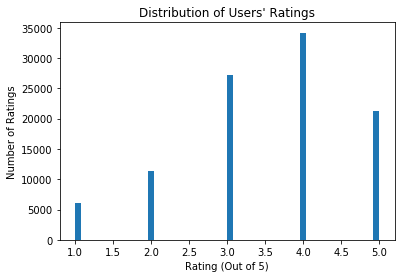

In [12]:
ratings.rating.plot.hist(bins=50)
plt.title("Distribution of Users' Ratings")
plt.ylabel('Number of Ratings')
plt.xlabel('Rating (Out of 5)')

In [13]:
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [19]:
ratings_matrix = ratings.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix.fillna( 0, inplace = True )
ratings_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
ratings_matrix.shape

(1682, 943)

In [36]:
#下面是计算Cosine Similarity
movie_similarity = 1 - pairwise_distances(ratings_matrix.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix = pd.DataFrame( movie_similarity )
ratings_matrix.shape

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(1682, 1682)

In [37]:
try:
    #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
    user_inp="Speed (1994)"
    inp=movies[movies['title']==user_inp].index.tolist()
    inp=inp[0]
    
    movies['similarity'] = ratings_matrix.iloc[inp]
    movies.columns = ['movie_id', 'title', 'release_date','similarity']
    movies.head(2)
    
except:
    print("Sorry, the movie is not in the database!")

In [38]:
print("Recommended movies based on your choice of ",user_inp ,": \n", movies.sort_values( ["similarity"], ascending = False )[1:10])

Recommended movies based on your choice of  Speed (1994) : 
      movie_id                                      title release_date  \
384       385                           True Lies (1994)  01-Jan-1994   
160       161                             Top Gun (1986)  01-Jan-1986   
78         79                       Fugitive, The (1993)  01-Jan-1993   
95         96          Terminator 2: Judgment Day (1991)  01-Jan-1991   
194       195                     Terminator, The (1984)  01-Jan-1984   
173       174             Raiders of the Lost Ark (1981)  01-Jan-1981   
209       210  Indiana Jones and the Last Crusade (1989)  01-Jan-1989   
549       550          Die Hard: With a Vengeance (1995)  01-Jan-1995   
203       204                  Back to the Future (1985)  01-Jan-1985   

     similarity  
384    0.719504  
160    0.707567  
78     0.696583  
95     0.695556  
194    0.676778  
173    0.676664  
209    0.674811  
549    0.674143  
203    0.665776  
